<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Question-1" data-toc-modified-id="Question-1-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Question 1</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Question 2</a></span></li></ul></div>

# Packages

In [1]:
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 400));


R version 3.6.2 (2019-12-12) -- "Dark and Stormy Night"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



In [2]:
using Query, HTTP, CSV, DataFrames

In [3]:
using Distributions, Statistics

In [4]:
using JuMP, Ipopt, ForwardDiff

# Setup

In [5]:
R"""
require(rethinking)
require(ggplot2)
require(dplyr)
require(tidyr)
"""

┌ Warning: RCall.jl: Loading required package: rethinking
│ Loading required package: rstan
│ Loading required package: StanHeaders
│ Loading required package: ggplot2
│ rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)
│ For execution on a local, multicore CPU with excess RAM we recommend calling
│ options(mc.cores = parallel::detectCores()).
│ To avoid recompilation of unchanged Stan programs, we recommend calling
│ rstan_options(auto_write = TRUE)
│ For improved execution time, we recommend calling
│ Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')
│ although this causes Stan to throw an error on a few processors.
│ Loading required package: parallel
│ Loading required package: dagitty
│ rethinking (Version 2.00)
│ 
│ Attaching package: 'rethinking'
│ 
│ The following object is masked from 'package:stats':
│ 
│     rstudent
│ 
└ @ RCall C:\Users\mshukri\.julia\packages\RCall\lAV2K\src\io.jl:113
┌ Warning: RCall.jl: Loading required package: dplyr
│ 
│ Attaching package: 'dplyr'

RObject{LglSxp}
[1] TRUE


# Data

Get the Howel1 dataset:

In [6]:
file_url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
df = HTTP.get(file_url).body |> IOBuffer |> CSV.read
head(df, 5)

┌ Warning: `head(df::AbstractDataFrame, n::Integer)` is deprecated, use `first(df, n)` instead.
│   caller = top-level scope at In[6]:3
└ @ Core In[6]:3


,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


# Question 1

**Question**

<img src="https://i.ibb.co/tLyJSsz/Untitled.png" alt="Untitled" border="0">

**Solution**

Get the adult heights:

In [7]:
adults = df |>
    @filter(_.age >= 18) |>
    DataFrame

first(adults, 5)

,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Build a linear regression model relating height with weight:

In [8]:
# the data in (x, y) format
data = zip(adults.weight, adults.height)
x̄ = mean(adults.weight)

# define the priors
prior_α = Normal(178, 20)
prior_β = LogNormal(0, 1)
prior_σ = Uniform(0, 50)

# log likelihood of the data
ll_data(α, β, σ) = begin
    log_probs = map(data) do (x, y)
        μ = α + β * (x - x̄)
        d = Normal(μ, σ)
        logpdf(d, y)
    end
    log_probs |> sum
end

# log of the joint probability of the priors, assuming independence
l_joint_priors(α, β, σ) = logpdf(prior_α, α) +
    logpdf(prior_β, β) +
    logpdf(prior_σ, σ)

objective_fn(α, β, σ) = ll_data(α, β, σ) + l_joint_priors(α, β, σ)


# maximize the objective function
model = Model(with_optimizer(Ipopt.Optimizer))

register(model, :objective_fn, 3, objective_fn, autodiff=true)

@variable(model, 98 <= α <= 258, start = rand(prior_α))
@variable(model, 0 <= β <= 10, start = rand(prior_β))
@variable(model, 0 <= σ <= 100, start = rand(prior_σ))

@NLobjective(model, Max, objective_fn(α, β, σ))

optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equ

Extract the covariance matrix and optimal points to build the posterior distribution:

In [9]:
optimal_points = [α, β, σ] .|> value

f(x::Vector) = begin
    α, β, σ = x
    objective_fn(α, β, σ)
end

H(x::Vector) = ForwardDiff.hessian(f, x)

covar_mat = inv(-1 * H(optimal_points)) .|> 
    x -> round(x, digits=5)

posterior_d = MultivariateNormal(optimal_points, covar_mat)

FullNormal(
dim: 3
μ: [154.60136751223152, 0.9032808863359431, 5.071880332232309]
Σ: [0.07307 -0.0 6.0e-5; -0.0 0.00176 -3.0e-5; 6.0e-5 -3.0e-5 0.03654]
)


Make predictions on the given individuals:

In [10]:
predict_heights(α, β, σ) = begin
    sample_weights = [45, 40, 65, 31, 53]
    μs = α .+ β .* (sample_weights .- x̄)
    ds = Normal.(μs, σ)
    ys = rand.(ds)
end

summarize_predictions(preds) = vcat(mean(preds), (rcall(:PI, preds, prob=0.89) |> rcopy)...);

In [11]:
sample_params = rand(posterior_d, 1000)

results = map(eachcol(sample_params)) do (α, β, σ)
   predict_heights(α, β, σ) 
end |> 
    m -> hcat(m...)' |>
    eachcol .|>
    summarize_predictions |>
    m -> hcat(m...)' .|>
    x -> round(x, digits=1)

5×3 Array{Float64,2}:
 154.7  146.7  163.2
 150.0  142.1  158.0
 172.9  164.5  181.3
 141.8  134.6  149.6
 161.9  153.4  169.8

Make each results nicer:

In [12]:
hcat([45, 40, 65, 31, 53], results) |>
    m -> DataFrame(m, [:weight, :Eh, :L89, :U89])

,weight,Eh,L89,U89
,Float64,Float64,Float64,Float64
1,45.0,154.7,146.7,163.2
2,40.0,150.0,142.1,158.0
3,65.0,172.9,164.5,181.3
4,31.0,141.8,134.6,149.6
5,53.0,161.9,153.4,169.8


# Question 2

**Question**
<img src="https://i.ibb.co/rbvHT5P/Untitled.png" alt="Untitled" border="0">

**Solution**

Build a linear model:

In [13]:
# the data in (x, y) format
data = zip(log.(df.weight), df.height)
x̄ = mean(log.(df.weight))

# define the priors
prior_α = Normal(178, 20)
prior_β = LogNormal(0, 1)
prior_σ = Uniform(0, 50)

# log likelihood of the data
ll_data(α, β, σ) = begin
    log_probs = map(data) do (x, y)
        μ = α + β * (x - x̄)
        d = Normal(μ, σ)
        logpdf(d, y)
    end
    log_probs |> sum
end

# log of the joint probability of the priors, assuming independence
l_joint_priors(α, β, σ) = logpdf(prior_α, α) +
    logpdf(prior_β, β) +
    logpdf(prior_σ, σ)

objective_fn(α, β, σ) = ll_data(α, β, σ) + l_joint_priors(α, β, σ)


# maximize the objective function
model = Model(with_optimizer(Ipopt.Optimizer))

register(model, :objective_fn, 3, objective_fn, autodiff=true)

@variable(model, 98 <= α <= 258, start = rand(prior_α))
@variable(model, 0 <= β <= 100, start = rand(prior_β))
@variable(model, 0 <= σ <= 100, start = rand(prior_σ))

@NLobjective(model, Max, objective_fn(α, β, σ))

optimize!(model)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [14]:
optimal_points = [α, β, σ] .|> value

f(x::Vector) = begin
    α, β, σ = x
    objective_fn(α, β, σ)
end

H(x::Vector) = ForwardDiff.hessian(f, x)

covar_mat = inv(-1 * H(optimal_points)) .|> 
    x -> round(x, digits=5)

posterior_d = MultivariateNormal(optimal_points, covar_mat)

FullNormal(
dim: 3
μ: [138.26841036791015, 47.07112766717237, 5.134717086790416]
Σ: [0.04846 -0.0 5.0e-5; -0.0 0.14641 -0.00014; 5.0e-5 -0.00014 0.02423]
)


Make predictions for weights starting from 1 kg to 60 kg:

In [15]:
const trials = 1000

sample_xs = range(1, stop=60)
sample_params = rand(posterior_d, trials)

# predict the heights for each x in sample_xs given a set of params sampled from the posterior
results = map(eachcol(sample_params)) do (α, β, σ)
    centered_sample_xs = log.(sample_xs) .- x̄
    sample_μs = α .+ β .* centered_sample_xs
    
    d = Normal.(sample_μs, σ)
    sample_heights = rand.(d)
end |>
    m -> hcat(m...)' |>
# summarize the predictions for each x in sampple_xs
    eachcol .|>
    (col -> vcat(mean(col), rcall(:PI, col, prob=0.99) |> rcopy)) |>
    m -> hcat(m...)'

results[1:5,:]

5×3 Array{Float64,2}:
 -24.0635   -37.0395   -11.2005
   8.73865   -4.91901   22.7802
  27.8314    14.5603    41.2942
  41.6801    29.105     53.4393
  52.0696    39.0495    65.3266

Turn results into a dataframe:

In [16]:
results_df = hcat(sample_xs, results) |>
    m -> DataFrame(m, [:weight, :height, :l99, :u99])

first(results_df, 5)

,weight,height,l99,u99
,Float64,Float64,Float64,Float64
1,1.0,-24.0635,-37.0395,-11.2005
2,2.0,8.73865,-4.91901,22.7802
3,3.0,27.8314,14.5603,41.2942
4,4.0,41.6801,29.105,53.4393
5,5.0,52.0696,39.0495,65.3266


Plot the results:

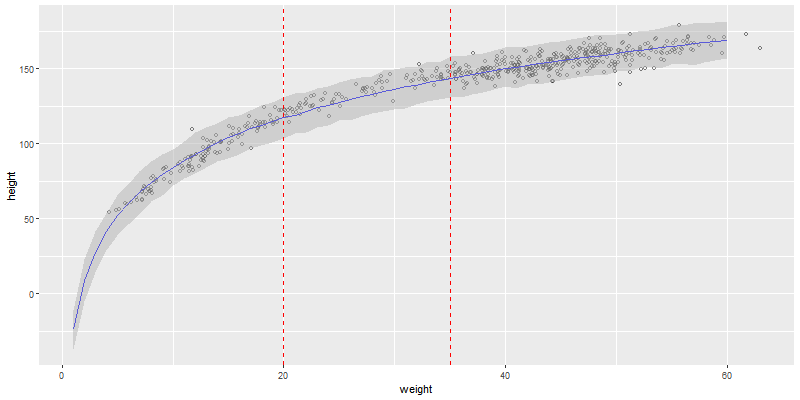

RObject{VecSxp}


In [17]:
R"""

$df %>%
  ggplot() +
  geom_point(aes(weight, height), alpha = 0.5, shape = 1) +
  geom_line(aes(weight, height), data = $results_df, color = "blue")  +
  geom_ribbon(
    aes(x = weight, ymin = l99, ymax = u99),
    data = $results_df,
    fill = "grey70",
    alpha = 0.5
  ) +
  geom_vline(xintercept = 20, color='red', linetype = 'dashed') +
  geom_vline(xintercept = 35, color='red', linetype = 'dashed')
"""

We can see that the model tends to underpredict the height for weight values between 20 kg and 35 kg. Otherwise, the model does a pretty got job when making predictions in regions where it has data.

What if we did not take the log of the weight?

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

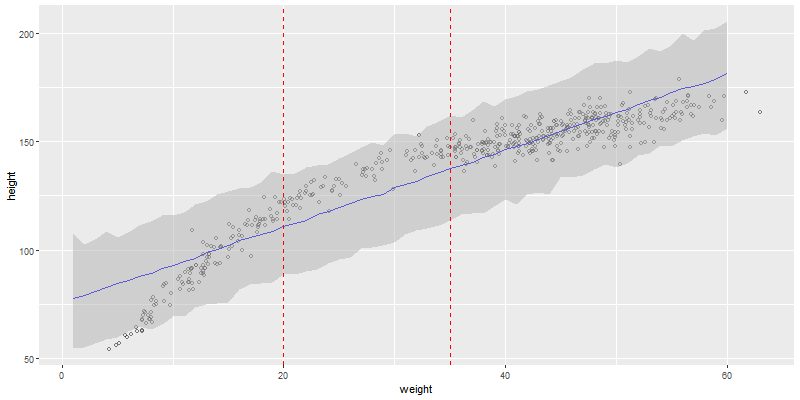

RObject{VecSxp}


In [18]:
# the data in (x, y) format
data = zip(df.weight, df.height)
x̄ = mean(df.weight)

# define the priors
prior_α = Normal(178, 20)
prior_β = LogNormal(0, 1)
prior_σ = Uniform(0, 50)

# log likelihood of the data
ll_data(α, β, σ) = begin
    log_probs = map(data) do (x, y)
        μ = α + β * (x - x̄)
        d = Normal(μ, σ)
        logpdf(d, y)
    end
    log_probs |> sum
end

# log of the joint probability of the priors, assuming independence
l_joint_priors(α, β, σ) = logpdf(prior_α, α) +
    logpdf(prior_β, β) +
    logpdf(prior_σ, σ)

objective_fn(α, β, σ) = ll_data(α, β, σ) + l_joint_priors(α, β, σ)


# maximize the objective function
model = Model(with_optimizer(Ipopt.Optimizer))

register(model, :objective_fn, 3, objective_fn, autodiff=true)

@variable(model, 98 <= α <= 258, start = rand(prior_α))
@variable(model, 0 <= β <= 100, start = rand(prior_β))
@variable(model, 0 <= σ <= 100, start = rand(prior_σ))

@NLobjective(model, Max, objective_fn(α, β, σ))

optimize!(model)

# build the posterior distribution
optimal_points = [α, β, σ] .|> value

f(x::Vector) = begin
    α, β, σ = x
    objective_fn(α, β, σ)
end

H(x::Vector) = ForwardDiff.hessian(f, x)

covar_mat = inv(-1 * H(optimal_points)) .|> 
    x -> round(x, digits=5)

posterior_d = MultivariateNormal(optimal_points, covar_mat)


# summarize the results
const trials = 1000

sample_xs = range(1, stop=60)
sample_params = rand(posterior_d, trials)

# predict the heights for each x in sample_xs given a set of params sampled from the posterior
results = map(eachcol(sample_params)) do (α, β, σ)
    centered_sample_xs = sample_xs .- x̄
    sample_μs = α .+ β .* centered_sample_xs
    
    d = Normal.(sample_μs, σ)
    sample_heights = rand.(d)
end |>
    m -> hcat(m...)' |>
# summarize the predictions for each x in sampple_xs
    eachcol .|>
    (col -> vcat(mean(col), rcall(:PI, col, prob=0.99) |> rcopy)) |>
    m -> hcat(m...)'

# plot the results
results_df = hcat(sample_xs, results) |>
    m -> DataFrame(m, [:weight, :height, :l99, :u99])

R"""

$df %>%
  ggplot() +
  geom_point(aes(weight, height), alpha = 0.5, shape = 1) +
  geom_line(aes(weight, height), data = $results_df, color = "blue")  +
  geom_ribbon(
    aes(x = weight, ymin = l99, ymax = u99),
    data = $results_df,
    fill = "grey70",
    alpha = 0.5
  ) +
  geom_vline(xintercept = 20, color='red', linetype = 'dashed') +
  geom_vline(xintercept = 35, color='red', linetype = 'dashed')
"""

It's alot worse!

Notice that both models are linear models. The only difference is that the first model makes the assumption that height is linearly related to the log of weight while the second model assumes height is linearly related to weight.

Why does taking the log of weight gives so much better result?

Hint: $log(x)$ can reasonably approximate  $x^{1/3}$

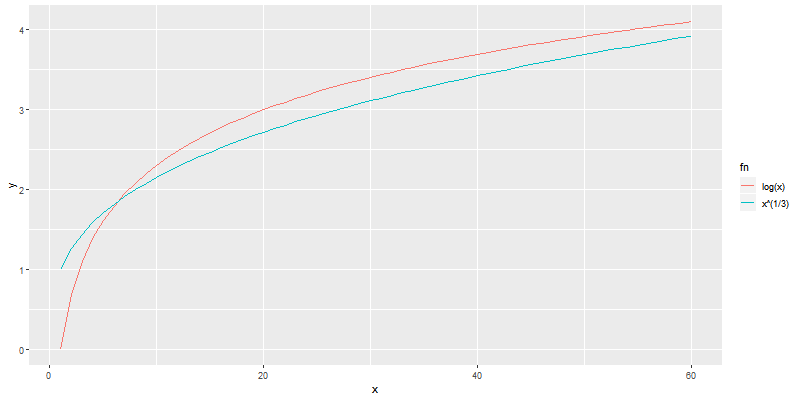

RObject{VecSxp}


In [19]:
x = range(1, stop = 60)
y1 = log.(x)
y2 = x.^(1/3)

df = hcat(x, y1, y2) |>
    m -> DataFrame(m, [:x, :y1, :y2])

R"""
$df %>%
    pivot_longer(c(y1, y2), names_to = 'fn', values_to = 'y') %>%
    mutate(fn = if_else(fn == 'y1', 'log(x)', 'x^(1/3)')) %>%
    ggplot(aes(x = x, y = y, color = fn)) +
    geom_line()

"""

If we assume the shape of a human can be approximated by a cylinder:

<img src="https://i.ibb.co/s2RqrXv/Untitled.png" alt="Untitled" border="0">

**Conclusion**:

Sometime physics/biology gets you most of the model.